In [81]:
# 共通で利用するライブラリ
import glob
import os
import datetime
import pickle
from natsort import natsorted
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings

# warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True, precision=3)
pd.options.display.float_format = "{:.4f}".format
pd.set_option("display.max_columns", None)
plt.style.use("seaborn")
plt.rcParams["font.size"] = 14
plt.rcParams["font.family"] = "IPAexGothic"
%matplotlib inline
%load_ext autoreload

# 追加するライブラリ
from dateutil.relativedelta import relativedelta
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Ch.09 小規模機械学習システムを作成する

- 月次で更新するタイミングで、データを蓄積する
- 蓄積されたデータをもとに毎月のモデル構築を行う
- データ一覧
  - m_area.csv
  - m_store.csv
  - tbl_order_202004.csv ~ tbl_order_202008.csv
  - store_monthly_data.csv
  - ml_base_data.csv
  - model_y_weekday_GradientBoosting.pickle
  - model_y_weekend_GradientBoosting.pickle
  - X_cols.csv

- フォルダ構成

```bash
ch09
├── ch09.ipynb
├── models
│   ├── model_y_weekday_GradientBoosting.pickle
│   ├── model_y_weekend_GradientBoosting.pickle
│   └── X_cols.csv
└── data
    ├── 00_input
    │   └── tbl_order_YYYYMM.csv
    ├── 01_store_monthly
    │   └── store_monthly_data.csv
    ├── 02_ml_base
    │   └── ml_base_data.csv
    ├── 10_output_ml_result
    │   └── results_xxxx
    ├── 11_output_report
    └── 99_master
```

### Knock81: フォルダを生成して初期の変数定義を行う

In [82]:
# フォルダ作成

data_dir = "data"

input_dir = os.path.join(data_dir, "00_input")
store_monthly_dir = os.path.join(data_dir, "01_store_monthly")
ml_base_dir = os.path.join(data_dir, "02_ml_base")

output_ml_result_dir = os.path.join(data_dir, "10_output_ml_result")
output_report_dir = os.path.join(data_dir, "11_output_report")

master_dir = os.path.join(data_dir, "99_master")
model_dir = "models"

os.makedirs(input_dir, exist_ok=True)
os.makedirs(store_monthly_dir, exist_ok=True)
os.makedirs(ml_base_dir, exist_ok=True)
os.makedirs(output_ml_result_dir, exist_ok=True)
os.makedirs(output_report_dir, exist_ok=True)
os.makedirs(master_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

In [83]:
# 初期変数の定義

# tg_ym = "202004"
# tg_ym = "202005"
# tg_ym = "202006"
# tg_ym = "202007"
tg_ym = "202008"

target_file = "tbl_order_" + tg_ym + ".csv"
m_area_file = "m_area.csv"
m_store_file = "m_store.csv"
store_monthly_file = "store_monthly_data.csv"
ml_base_file = "ml_base_data.csv"


### Knock82: 更新データを読み込んで店舗別データを作成する

In [84]:
# 更新データの読み込み

m_area = pd.read_csv(os.path.join(master_dir, m_area_file))
m_store = pd.read_csv(os.path.join(master_dir, m_store_file))
target_data = pd.read_csv(os.path.join(input_dir, target_file))

# データの年月チェック
max_date = pd.to_datetime(target_data["order_accept_date"]).max()
min_date = pd.to_datetime(target_data["order_accept_date"]).min()
max_str_date = max_date.strftime("%Y%m")
min_str_date = min_date.strftime("%Y%m")
if (tg_ym == min_str_date) and (tg_ym == max_str_date):
    print("年月が一致しました。")
else:
    raise Exception("年月が一致しません。")

年月が一致しました。


In [85]:
# 店舗別集計を行うための関数

def calc_delta(t):
    """
    経過時間を計算する
    戻り値は単位（分）
    """
    t1, t2 = t
    delta = t2 - t1
    return delta.total_seconds() / 60

# 1か月分データから店舗別に集計する


def data_processing(order_data, m_area, m_store) :
    """
    データの加工関数
    店舗ごとに集計する
    """

    # 店舗No.999の除外
    order_data = order_data.loc[order_data["store_id"] != 999]

    # オーダーデータにマスタデータを結合
    order_data = pd.merge(order_data, m_store, on="store_id", how="left")
    order_data = pd.merge(order_data, m_area, on="area_cd", how="left")

    # テイクアウト名の追加
    order_data.loc[order_data["takeout_flag"] == 0, "takeout_name"] = "デリバリー"
    order_data.loc[order_data["takeout_flag"] == 1, "takeout_name"] = "お持ち帰り"

    # ステイタス名の追加
    order_data.loc[order_data["status"] == 0, "status_name"] = "受付"
    order_data.loc[order_data["status"] == 1, "status_name"] = "お支払済"
    order_data.loc[order_data["status"] == 2, "status_name"] = "お渡し済"
    order_data.loc[order_data["status"] == 9, "status_name"] = "キャンセル"

    # ピザ提供までの時間
    order_data.loc[:, "order_accept_datetime"] = pd.to_datetime(order_data["order_accept_date"])
    order_data.loc[:, "delivered_datetime"] = pd.to_datetime(order_data["delivered_date"])
    order_data.loc[:, "delta"] = order_data[[
        "order_accept_datetime", "delivered_datetime"]].apply(calc_delta, axis=1)

    # ピザが注文された時間帯を追加
    order_data.loc[:, "order_accept_hour"] = order_data["order_accept_datetime"].dt.hour
    order_data.loc[:, "order_accept_weekday"] = order_data["order_accept_datetime"].dt.weekday
    # 平日/休日を追加
    order_data.loc[order_data["order_accept_weekday"] < 5, "weekday_info"] = "平日"
    order_data.loc[order_data["order_accept_weekday"] >= 5, "weekday_info"] = "休日"

    # 店舗単位の集計
    # 総オーダー数
    store_data = order_data.groupby(["store_name"]).count()[["order_id"]]
    # 完了しているオーダー数
    store_f = order_data.loc[
        (order_data["status_name"] == "お渡し済") | (order_data["status_name"] == "お支払済")
    ].groupby(["store_name"]).count()[["order_id"]]
    # キャンセル数
    store_c = order_data.loc[
        order_data["status_name"] == "キャンセル"
    ].groupby(["store_name"]).count()[["order_id"]]
    # デリバリー数
    store_d = order_data.loc[
        order_data["takeout_name"] == "デリバリー"
    ].groupby(["store_name"]).count()[["order_id"]]
    # お持ち帰り数
    store_t = order_data.loc[
        order_data["takeout_name"] == "お持ち帰り"
    ].groupby(["store_name"]).count()[["order_id"]]
    # 平日オーダー数
    store_weekday = order_data.loc[
        order_data["weekday_info"] == "平日"
    ].groupby(["store_name"]).count()[["order_id"]]
    # 休日オーダー数
    store_weekend = order_data.loc[
        order_data["weekday_info"] == "休日"
    ].groupby(["store_name"]).count()[["order_id"]]

    # 時間帯別オーダー数の集計
    times = order_data["order_accept_hour"].unique()
    store_time = []
    for time in times:
        time_tmp = order_data.loc[
            order_data["order_accept_hour"] == time
        ].groupby(["store_name"]).count()[["order_id"]]
        time_tmp.columns = [f"order_time_{time}"]
        store_time.append(time_tmp)
    store_time = pd.concat(store_time, axis=1)

    # ピザ提供までの時間の平均時間
    store_delta = order_data.loc[
        order_data["status_name"] != "キャンセル"
    ].groupby(["store_name"]).mean()[["delta"]]

    # 各データの項目設定
    store_data.columns = ["order"]
    store_f.columns = ["order_fin"]
    store_c.columns = ["order_cancel"]
    store_d.columns = ["order_delivery"]
    store_t.columns = ["order_takeout"]
    store_weekday.columns = ["order_weekday"]
    store_weekend.columns = ["order_weekend"]
    store_delta.columns = ["delta_avg"]

    # 各データを結合
    store_data = pd.concat([
        store_data, store_f, store_c, store_d, store_t,
        store_weekday, store_weekend, store_time, store_delta
    ], axis=1)

    return store_data


In [86]:
# 店舗別集計データの作成

store_data = data_processing(target_data, m_area, m_store)
store_data.reset_index(drop=False, inplace=True)
store_data.loc[:, "year_month"] = tg_ym

display(store_data.head(1))

,store_name,order,order_fin,order_cancel,order_delivery,order_takeout,order_weekday,order_weekend,order_time_11,order_time_12,order_time_13,order_time_14,order_time_15,order_time_16,order_time_17,order_time_18,order_time_19,order_time_20,order_time_21,delta_avg,year_month
0,あきる野店,1179,941,238,846,333,802,377,108,101,113,114,105,99,108,94,109,111,117,35.1488,202008


### Knock83: 月次店舗データを更新する

In [87]:
# 店舗別データの追加更新

store_monthly_data = pd.read_csv(os.path.join(store_monthly_dir, store_monthly_file))
print(f"更新前: {len(store_monthly_data)}件")

store_monthly_data = pd.concat(
    [store_monthly_data, store_data], ignore_index=True, axis=0
)
store_monthly_data.loc[:, "year_month"] = store_monthly_data["year_month"].astype(str)

# 重複データの削除
store_monthly_data.drop_duplicates(
    subset=["store_name", "year_month"], inplace=True, keep="last"
)
print(f"更新後: {len(store_monthly_data)}件")

# データの出力
store_monthly_data.to_csv(os.path.join(store_monthly_dir, store_monthly_file), index=False)


更新前: 3120件
更新後: 3315件


### Knock84: 機械学習用データの作成と更新を行う

In [88]:
# 機械学習用データの作成

y = store_monthly_data[[
    "store_name", "year_month", "order_weekday", "order_weekend"
]].copy()

y.loc[:, "one_month_ago"] = pd.to_datetime(y["year_month"], format="%Y%m")
y.loc[:, "one_month_ago"] = y["one_month_ago"].map(
    lambda x: x - relativedelta(months=1)
)
y.loc[:, "one_month_ago"] = y["one_month_ago"].dt.strftime("%Y%m")

y_one_month_ago = y.copy()
y_one_month_ago.rename(columns={
    "order_weekday": "order_weekday_one_month_ago",
    "order_weekend": "order_weekend_one_month_ago",
    "year_month": "year_month_for_join"
}, inplace=True)

y = pd.merge(
    y, 
    y_one_month_ago[[
        "store_name", "year_month_for_join", 
        "order_weekday_one_month_ago", "order_weekend_one_month_ago"
    ]],
    left_on=["store_name", "one_month_ago"],
    right_on=["store_name", "year_month_for_join"],
    how="left"
)

y.dropna(inplace=True)
y.loc[
    y["order_weekday"] - y["order_weekday_one_month_ago"] > 0,
    "y_weekday"
] = 1
y.loc[
    y["order_weekday"] - y["order_weekday_one_month_ago"] <= 0,
    "y_weekday"
] = 0
y.loc[
    y["order_weekend"] - y["order_weekend_one_month_ago"] > 0,
    "y_weekend"
] = 1
y.loc[
    y["order_weekend"] - y["order_weekend_one_month_ago"] <= 0,
    "y_weekend"
] = 0

y.rename(columns={"year_month": "target_year_month"}, inplace=True)
y = y[[
    "store_name", "target_year_month", "one_month_ago",
    "y_weekday", "y_weekend"
]].copy()

ml_data = pd.merge(
    y, store_monthly_data,
    left_on=["store_name", "one_month_ago"],
    right_on=["store_name", "year_month"],
    how="left"
)
del ml_data["target_year_month"]
del ml_data["one_month_ago"]

display(ml_data.head(3))


,store_name,y_weekday,y_weekend,order,order_fin,order_cancel,order_delivery,order_takeout,order_weekday,order_weekend,order_time_11,order_time_12,order_time_13,order_time_14,order_time_15,order_time_16,order_time_17,order_time_18,order_time_19,order_time_20,order_time_21,delta_avg,year_month
0,あきる野店,1.0000,0.0000,1147,945,202,841,306,844,303,91,122,112,101,95,107,106,100,108,109,96,34.1101,201904
1,さいたま南店,1.0000,1.0000,1504,1217,287,1105,399,1104,400,130,135,147,143,142,137,130,113,140,132,155,35.3377,201904
2,さいたま緑店,1.0000,1.0000,1028,847,181,756,272,756,272,95,91,106,95,102,82,90,93,95,95,84,34.2916,201904


In [89]:
# 機械学習用データの更新

ml_base_data = pd.read_csv(os.path.join(ml_base_dir, ml_base_file))
print(f"更新前: {len(ml_base_data)}件")

ml_base_data = pd.concat([ml_base_data, ml_data], ignore_index=True)
ml_base_data.loc[:, "year_month"] = ml_base_data["year_month"].astype(str)
ml_base_data.drop_duplicates(
    subset=["store_name", "year_month"], inplace=True, keep="last"
)
print(f"更新後: {len(ml_base_data)}件")

ml_base_data.to_csv(os.path.join(ml_base_dir, ml_base_file), index=False)


更新前: 2925件
更新後: 3120件


### Knock85: 機械学習モデル用の事前データ加工を行う

In [90]:
# 機械学習用の事前データ加工

# One-Hotエンコーディング
category_data = pd.get_dummies(
    ml_base_data["store_name"], prefix="store", prefix_sep="_"
)
del category_data["store_麻生店"]
del ml_base_data["year_month"]
del ml_base_data["store_name"]
ml_base_data = pd.concat([ml_base_data, category_data], axis=1)

# データ分割
train_data, test_data = train_test_split(
    ml_base_data, test_size=0.3, random_state=0
)

print(f"Train: {len(train_data)}件 / Test: {len(test_data)}件")

print(f"Weekday Train_0: {len(train_data.loc[train_data['y_weekday'] == 0])}件")
print(f"Weekday Train_1: {len(train_data.loc[train_data['y_weekday'] == 1])}件")
print(f"Weekday Test_0: {len(test_data.loc[test_data['y_weekday'] == 0])}件")
print(f"Weekday Test_1: {len(test_data.loc[test_data['y_weekday'] == 1])}件")

print(f"Weekend Train_0: {len(train_data.loc[train_data['y_weekend'] == 0])}件")
print(f"Weekend Train_1: {len(train_data.loc[train_data['y_weekend'] == 1])}件")
print(f"Weekend Test_0: {len(test_data.loc[test_data['y_weekend'] == 0])}件")
print(f"Weekend Test_1: {len(test_data.loc[test_data['y_weekend'] == 1])}件")

Train: 2184件 / Test: 936件
Weekday Train_0: 1016件
Weekday Train_1: 1168件
Weekday Test_0: 462件
Weekday Test_1: 474件
Weekend Train_0: 1060件
Weekend Train_1: 1124件
Weekend Test_0: 436件
Weekend Test_1: 500件


### Knock86: 機械学習モデルの構築・評価を行う

In [91]:
# モデル構築と評価を行う関数

def make_model_and_eval(model, X_train, X_test, y_train, y_test):
    """
    モデル構築と評価を行う
    """
    # モデル構築
    model.fit(X_train, y_train)
    # 予測
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # accuracy
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred_test)

    # recall
    recall_train = recall_score(y_train, y_pred_train)
    recall_test = recall_score(y_test, y_pred_test)

    # precision
    precision_train = precision_score(y_train, y_pred_train)
    precision_test = precision_score(y_test, y_pred_test)

    # F-score
    f1_train = f1_score(y_train, y_pred_train)
    f1_test = f1_score(y_test, y_pred_test)

    # 混合行列データ train
    tn_train, fp_train, fn_train, tp_train = confusion_matrix(
        y_train, y_pred_train
    ).ravel()
    # 混合行列データ test
    tn_test, fp_test, fn_test, tp_test = confusion_matrix(
        y_test, y_pred_test
    ).ravel()

    # 精度指標のデータフレーム化
    score_train = pd.DataFrame({
        "DataCategory": ["train"],
        "accuracy": [accuracy_train],
        "recall": [recall_train],
        "precision": [precision_train],
        "f1": [f1_train],
        "tn": [tn_train],
        "fp": [fp_train],
        "fn": [fn_train],
        "tp": [tp_train]
    })
    score_test = pd.DataFrame({
        "DataCategory": ["test"],
        "accuracy": [accuracy_test],
        "recall": [recall_test],
        "precision": [precision_test],
        "f1": [f1_test],
        "tn": [tn_test],
        "fp": [fp_test],
        "fn": [fn_test],
        "tp": [tp_test]
    })
    score = pd.concat([score_train, score_test], ignore_index=True)

    # モデルの重要度
    importance = pd.DataFrame({
        "cols": X_train.columns,
        "importance": model.feature_importances_
    })
    importance = importance.sort_values("importance", ascending=False)

    # 説明変数の列名
    cols = pd.DataFrame({"X_cols": X_train.columns})

    # 表示
    display(score)

    return score, importance, model, cols


In [92]:
# アルゴリズム選択
# 平日・休日モデルの構築
# ファイル出力


X_cols = list(train_data.columns)
X_cols.remove("y_weekday")
X_cols.remove("y_weekend")

targets_y = ["y_weekday", "y_weekend"]

# 出力フォルダの作成
target_output_dir_name = "result_" + tg_ym
target_output_dir = os.path.join(output_ml_result_dir, target_output_dir_name)
os.makedirs(target_output_dir, exist_ok=True)
print(target_output_dir)

score_all = []
importance_all = []

for target_y in targets_y:
    y_train = train_data[target_y]
    X_train = train_data[X_cols]
    y_test = test_data[target_y]
    X_test = test_data[X_cols]

    # モデルの定義
    models = {
        "tree": DecisionTreeClassifier(random_state=0),
        "RandomForest": RandomForestClassifier(random_state=0),
        "GradientBoosting": GradientBoostingClassifier(random_state=0)
    }

    for model_name, model in models.items():
        # モデル構築・評価
        print(target_y, model_name)
        score, importance, model, cols = make_model_and_eval(
            model, X_train, X_test, y_train, y_test
        )
        score["model_name"] = model_name
        importance["model_name"] = model_name
        score["model_target"] = target_y
        importance["model_target"] = target_y

        # モデル保存（pickle）
        model_name = f"model_{target_y}_{model_name}.pickle"
        model_path = os.path.join(target_output_dir, model_name)
        with open(model_path, mode="wb") as f:
            pickle.dump(model, f, protocol=2)

        score_all.append(score)
        importance_all.append(importance)

# データフレーム化
score_all = pd.concat(score_all, ignore_index=True)
importance_all = pd.concat(importance_all, ignore_index=True)
cols = pd.DataFrame({"X_cols": X_train.columns})

# ファイル名作成
score_name = "score.csv"
importance_name = "importance.csv"
cols_name = "X_cols.csv"

# 保存先パス作成
score_path = os.path.join(target_output_dir, score_name)
importance_path = os.path.join(target_output_dir, importance_name)
cols_path = os.path.join(target_output_dir, cols_name)

# ファイル保存
score_all.to_csv(score_path, index=False)
importance_all.to_csv(importance_path, index=False)
cols.to_csv(cols_path, index=False)


data/10_output_ml_result/result_202008
y_weekday tree


,DataCategory,accuracy,recall,precision,f1,tn,fp,fn,tp
0,train,1.0000,1.0000,1.0000,1.0000,1016,0,0,1168
1,test,0.7821,0.7911,0.7812,0.7862,357,105,99,375


y_weekday RandomForest


,DataCategory,accuracy,recall,precision,f1,tn,fp,fn,tp
0,train,1.0000,1.0000,1.0000,1.0000,1016,0,0,1168
1,test,0.7618,0.7827,0.7556,0.7689,342,120,103,371


y_weekday GradientBoosting


,DataCategory,accuracy,recall,precision,f1,tn,fp,fn,tp
0,train,0.8228,0.8159,0.8471,0.8312,844,172,215,953
1,test,0.7735,0.7658,0.7823,0.7740,361,101,111,363


y_weekend tree


,DataCategory,accuracy,recall,precision,f1,tn,fp,fn,tp
0,train,1.0000,1.0000,1.0000,1.0000,1060,0,0,1124
1,test,0.7831,0.8000,0.7952,0.7976,333,103,100,400


y_weekend RandomForest


,DataCategory,accuracy,recall,precision,f1,tn,fp,fn,tp
0,train,1.0000,1.0000,1.0000,1.0000,1060,0,0,1124
1,test,0.8397,0.8480,0.8514,0.8497,362,74,76,424


y_weekend GradientBoosting


,DataCategory,accuracy,recall,precision,f1,tn,fp,fn,tp
0,train,0.8599,0.8452,0.8780,0.8613,928,132,174,950
1,test,0.8472,0.8440,0.8665,0.8551,371,65,78,422


### Knock87: 新規データ予測に向けた準備をする

In [93]:
# 予測データに向けたデータ準備

category_data = pd.get_dummies(
    store_data["store_name"], prefix="store", prefix_sep="_"
)
del category_data["store_麻生店"]

store_data = pd.concat([store_data, category_data], axis=1)

X_cols_name = "X_cols.csv"
X_cols = pd.read_csv(os.path.join(model_dir, X_cols_name))
X_cols = X_cols["X_cols"]

X = store_data[X_cols].copy()

In [94]:
# モデルファイルの読み込み

model_weekday_name = "model_y_weekday_GradientBoosting.pickle"
model_weekend_name = "model_y_weekend_GradientBoosting.pickle"

model_weekday_path = os.path.join(model_dir, model_weekday_name)
model_weekend_path = os.path.join(model_dir, model_weekend_name)

with open(model_weekday_path, mode="rb") as f:
    model_weekday = pickle.load(f)

with open(model_weekend_path, mode="rb") as f:
    model_weekend = pickle.load(f)


### Knock88: 新規データの予測を行う

In [95]:
# 新規データ予測

pred_weekday = model_weekday.predict(X)
pred_weekend = model_weekend.predict(X)

pred_proba_weekday = model_weekday.predict_proba(X)[:, 1]
pred_proba_weekend = model_weekend.predict_proba(X)[:, 1]

pred = pd.DataFrame({
    "pred_weekday": pred_weekday,
    "pred_weekend": pred_weekend,
    "score_weekday": pred_proba_weekday,
    "score_weekend": pred_proba_weekend,
})
pred.loc[:, "store_name"] = store_data["store_name"]
pred.loc[:, "year_month"] = tg_ym

display(pred)

,pred_weekday,pred_weekend,score_weekday,score_weekend,store_name,year_month
0,1.0000,0.0000,0.9564,0.3370,あきる野店,202008
1,1.0000,0.0000,0.9306,0.0952,さいたま南店,202008
2,1.0000,0.0000,0.8974,0.1717,さいたま緑店,202008
3,1.0000,0.0000,0.9321,0.1369,さいたま西店,202008
4,1.0000,0.0000,0.9406,0.1125,つくば店,202008
...,...,...,...,...,...,...
190,1.0000,0.0000,0.9538,0.1454,高津店,202008
191,1.0000,0.0000,0.9577,0.1497,高田馬場店,202008
192,1.0000,0.0000,0.9319,0.1319,鴻巣店,202008
193,1.0000,0.0000,0.9439,0.1012,鶴見店,202008


### Knock89: 現場向けレポートを作成して出力する

In [96]:
# 実績データの作成

target_cols = [
    "store_name", "order", "order_fin", "order_cancel", "order_delivery",
    "order_takeout", "order_weekday", "order_weekend", "delta_avg"
]
store_data = store_data[target_cols]

actual_cols = ["store_name"]
rename_cols = [
    x + f"_{tg_ym}" for x in store_data.columns if x != "store_name"
]
actual_cols.extend(rename_cols)
store_data.columns = actual_cols

display(store_data)

,store_name,order_202008,order_fin_202008,order_cancel_202008,order_delivery_202008,order_takeout_202008,order_weekday_202008,order_weekend_202008,delta_avg_202008
0,あきる野店,1179,941,238,846,333,802,377,35.1488
1,さいたま南店,1540,1253,287,1110,430,1047,493,34.4757
2,さいたま緑店,1067,881,186,787,280,725,342,34.6765
3,さいたま西店,1216,987,229,891,325,822,394,35.1317
4,つくば店,1308,1067,241,958,350,886,422,35.0141
...,...,...,...,...,...,...,...,...,...
190,高津店,1153,926,227,857,296,784,369,35.5184
191,高田馬場店,1096,880,216,820,276,742,354,33.3523
192,鴻巣店,1152,940,212,844,308,783,369,34.7436
193,鶴見店,1515,1257,258,1114,401,1023,492,34.4614


In [97]:
# 現場向けレポートの作成

# 予測確率（score）の簡易化 平日モデル
pred.loc[pred["score_weekday"] >= 0.75, "オーダー予測 平日"] = "増加大"
pred.loc[
    (0.5 <= pred["score_weekday"]) & (pred["score_weekday"] < 0.75),
    "オーダー予測 平日"
] = "増加"
pred.loc[
    (0.25 <= pred["score_weekday"]) & (pred["score_weekday"] < 0.5),
    "オーダー予測 平日"
] = "減少"
pred.loc[pred["score_weekday"] < 0.25, "オーダー予測 平日"] = "減少大"

# 予測確率（score）の簡易化 休日モデル
pred.loc[pred["score_weekend"] >= 0.75, "オーダー予測 休日"] = "増加大"
pred.loc[
    (0.5 <= pred["score_weekend"]) & (pred["score_weekend"] < 0.75),
    "オーダー予測 休日"
] = "増加"
pred.loc[
    (0.25 <= pred["score_weekend"]) & (pred["score_weekend"] < 0.5),
    "オーダー予測 休日"
] = "減少"
pred.loc[pred["score_weekend"] < 0.25, "オーダー予測 休日"] = "減少大"

# 実績データの結合
report = pred[[
    "store_name", "オーダー予測 平日", "オーダー予測 休日",
    "score_weekday", "score_weekend"
]]
report = pd.merge(
    report, store_data, on="store_name", how="left"
)

# 予測年月の計算
pred_ym = datetime.datetime.strptime(tg_ym, "%Y%m")
pred_ym = pred_ym + relativedelta(months=1)
pred_ym = datetime.datetime.strftime(pred_ym, "%Y%m")

# レポートの保存
report_name = f"report_pred_{pred_ym}.xlsx"
print(report_name)
report.to_excel(os.path.join(output_report_dir, report_name), index=False)


report_pred_202009.xlsx


### Knock90: 機械学習モデルの精度推移を可視化する

In [105]:
# モデル精度評価の結果を結合する

ml_results_dirs = os.listdir(output_ml_result_dir)

score_all = []

for ml_results_dir in ml_results_dirs:
    score_file_path = os.path.join(
        output_ml_result_dir, ml_results_dir, "score.csv"
    )
    score_monthly = pd.read_csv(score_file_path)
    score_monthly["dirs"] = ml_results_dir
    score_all.append(score_monthly)

score_all = pd.concat(score_all, ignore_index=True)

display(score_all.head())

,DataCategory,accuracy,recall,precision,f1,tn,fp,fn,tp,model_name,model_target,dirs
0,train,1.0000,1.0000,1.0000,1.0000,777,0,0,861,tree,y_weekday,result_202004
1,test,0.8120,0.8184,0.8399,0.8290,250,61,71,320,tree,y_weekday,result_202004
2,train,1.0000,1.0000,1.0000,1.0000,777,0,0,861,RandomForest,y_weekday,result_202004
3,test,0.7920,0.8286,0.8040,0.8161,232,79,67,324,RandomForest,y_weekday,result_202004
4,train,0.8651,0.9001,0.8516,0.8752,642,135,86,775,GradientBoosting,y_weekday,result_202004


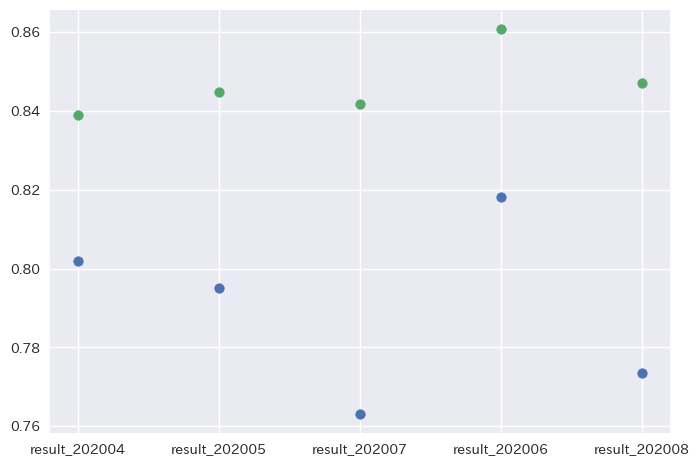

In [106]:
# モデル精度評価結果の推移
# GradientBoosting Test

score_all_gb = score_all.loc[
    (score_all["model_name"] == "GradientBoosting") &\
    (score_all["DataCategory"] == "test")
]

model_targets = score_all_gb["model_target"].unique()
for model_target in model_targets:
    view_data = score_all_gb.loc[score_all_gb["model_target"] == model_target]
    plt.scatter(view_data["dirs"], view_data["accuracy"])
